In [1]:
# Fix RTL in nbviewer
from IPython.display import HTML
HTML("<style>.jp-RenderedMarkdown { direction: rtl;} .jp-RenderedMarkdown p { text-align: right;}</style>")

# סיווג סרטים באמצעות ניתוח סנטימנטלי
#### פרוייקט סופי במסגרת סדנה במדעי הנתונים
**מגיש**: איתם יוגב

## הקדמה

המטרה שלי בפרוייקט היא ניתוח סנטימנטלי של סצנות סרטים, וניסיון לקישור בין רמות הסנטימנטים לאורך הסרט ובין סיווג הז'אנרים של הסרט. המשימה של סיווג סרטים לז'אנרים נראית פשוטה ממבט ראשון אך היא אינה טריוויאלית, שכן לא ניתן להסיק אותה באופן מיידי ממידע כלשהו על הסרט, והיא מצריכה ידע רחב ותושמת לב לדקויות. כמו כן, ז'אנר הוא אינו מאפיין בודד אחד, ובדרך כלל סרט יכול להשתייך לכמה ז'אנרים, וגם זה במידות שונות.

הרבה חברות סטרימינג גדולות כמו נטפליקס משתמשות בסיווג ז'אנרים כדי לזהות דמיון בין תכנים, וכך לתת למשתמש הצעות שיותר יתאימו לטעמו. קיימות שיטות רבות לסיווג ז'אנרים בעזרת למידת מכונה המשתמשות למשל בכותרת הסרט, תיאור הסרט טריילר ועוד.

בפרוייקט שלי אבחן את הרעיון של סנטימנטים במשפטים מתוך הסרט כבעלי קורלציה לז'אנרים של הסרט. ניתוח התוכן עצמו של הסרט מאתגר יותר מאשר ניתוח נתונים נלווים, אך הוא מאפשר ניתוח מעמיק יותר והתייחסות לפרטים נוספים חשובים כמו ציר הזמן, הדמויות השונות, עוצמת הרגש וכו' מה שלא ניתן כאשר מנתחים למשל את התקציר. בנוסף מציאת קורלציה בין סנטימנטים וז'אנרים יכולה לעבוד גם בכיוון ההפוך - בהינתן סרט בעל ז'אנר מסויים, תהיה אפשרות להגיד מהן התכונות של הדיאלוגים במהלך הסרט שעלינו לחפש בסרט מסוג זה.

### אתגרים ומגבלות מהותיות

הרבה מהדיאלוגים בסרט הם בעלי סאבטקסט וטונים שלא ניתן לחלץ מתוך הטקסט לבדו

## נתונים

מאגר הנתונים שבחרתי עבור הפרויקט הוא מאגר דיאלוגים בסרטים של אוניב' קורנל, שנמצא ב- 
[Kaggle](https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus)

המאגר מכיל מידע טקסטואלי שחולץ מ-617 תסריטי סרטים באנגלית, ו-304,713 משפטים שנאמרו בסרטים. עבור כל סרט הוא מכיל מידע על השורות שנאמרו, אילו שורות שייכות לאותו דיאלוג או שיחה בסרט, על ידי מי נאמרה השורה ומיהן הדמויות בסרט. כמו כן לכל סרט יש מידע שנלקח מIMDB המכיל גם את הז'אנרים.

נבצע טעינה של הטבלאות ל-DataFrames של pandas.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')

In [15]:
meta.sample(5)

,title,year,rating,no. votes,genres,genre_list
movie_id,,,,,,
m491,rocky,1976,8.1,100022,['drama' 'romance' 'sport'],"[sport, romance, drama]"
m403,jaws 2,1978,5.6,18995,['thriller'],[thriller]
m92,house of 1000 corpses,2003,5.6,27033,['horror'],[horror]
m522,some like it hot,1959,8.4,68749,['comedy'],[comedy]
m178,sideways,2004,7.8,70349,['comedy' 'drama' 'romance'],"[comedy, romance, drama]"


עבור הטבלאות movie_lines ו-movie_conversations, מבחינה ראשונית נראה שיש שורות בפורמט לא תקין. בחרתי לוותר על שורות אלו (עם `on_bad_lines=skip`). 

In [17]:
line_cols = ['line_id', 'character_id', 'movie_id', 'character_name', 'text']
lines = pd.read_table('./datasets/movie-dialog-corpus/movie_lines.tsv', sep='\t',
                      header=None, names=line_cols, index_col='line_id', on_bad_lines='skip')

conv_cols = ['first_char', 'second_char', 'movie_id', 'line_ids']
convos = pd.read_table(
    './datasets/movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None, names=conv_cols, on_bad_lines='skip')

## עיבוד מקדים

בטבלת הסרטים (meta) עמודת הז'אנרים היא string מהצורה ['comedy' 'musical']. נמיר את הנתונים בעמודה ל-list: 

In [9]:
def str_to_list(str: str):
    s = str.strip('\'[]')
    return list(set(s.split("\' \'") if s else []))

meta['genre_list'] = meta.genres.apply(str_to_list)

אם נבחן את את טיב הנתונים בטבלת השורות, נראה כי קיימות שורות לא תקינות. למשל:
- שורות ריקות
- שורות עם תיאור שנלקח מהתסריט, שאינו חלק מהשורה
- שורות עם סימני HTML
- שורות עם סימנים רנדומליים
- שורות המכילות תווים לא מוכרים, נובע מהבדלים ב-encoding

In [7]:
print(lines.loc['L24609'].text)
print(lines.loc['L265057'].text)
print(lines.loc['L55857'].text)
print(lines.loc['L545466'].text)
print(lines.loc['L523286'].text)

nan
I think that's... {HE STARTS TO RISE AND THE MEETING BEGINS TO BREAK UP) Starling I'm sure these gentlemen...
And his 'egghead' son!  We'll give 'em a <u>rough</u> <u>reception</u> won't we?
An anti-matter discharge directly ahead=8A it might disrupt the field long enough for us to break away.
You know what? Im not having this conversation right now.


לכן ראשית נצטרך לבצע preprocessing כדי לטייב את הטקסטים. אם נעבור על הטקסטים בעזר ביטוי רגולרי, נמצא כי קיימים מספר סימנים חריגים:

In [8]:
import re

def invalid_chars(txt):
    match = re.search("([^\w\s\d!?.,'\"-:;])", txt)
    return list(match.groups()) if match else []

matches = lines.dropna().text.apply(invalid_chars)
matches[matches.apply(lambda x : len(x) > 0)].explode().unique()

array(['<', '`', '\xad', '\x97', '[', '\x96', '~', '^', '=', '\x82',
       '\x93', '\x92', '|', '{', '\x91', ']', '\x8a', '>', '\x8c', '˛'],
      dtype=object)

רוב הסימנים המתחילים ב-x\ הם סימנים שנאבדו בגלל בעיית encoding, כולל כמה מופעים של =. נתקן את מה שנוכל, ומהשאר נתעלם: 

In [19]:
import re

def fix_windows_encoding(match):
    return match.group(0).encode('utf-8')[1:].decode('cp1252')

def preprocess_text(text):
    # fix encoding
    text = re.sub('[\x97\x96\x82\x93\x92\x91]', fix_windows_encoding, text)
    text = re.sub('=\w+ ', ' ', text)
    
    # remove html symbols
    text = re.sub('<.+>', ' ', text)
    text = re.sub('&[a-z]+;', ' ', text)
    
    # remove transcripts
    text = re.sub('{.+\)', ' ', text)
    
    # ignore everything else
    return re.sub('[^\w\s\d!?.,\'"-:;—’“‚–`˛‘’]', '', text)

lines = lines.dropna()
lines['text_pp'] = lines.text.apply(preprocess_text)

In [10]:
print(lines.loc['L265057'].text_pp)
print(lines.loc['L55857'].text_pp)
print(lines.loc['L545466'].text_pp)
print(lines.loc['L523286'].text_pp)

I think that's...   Starling I'm sure these gentlemen...
And his 'egghead' son!  We'll give 'em a   won't we?
An anti-matter discharge directly ahead it might disrupt the field long enough for us to break away.
You know what? I’m not having this conversation right now.


## EDA

### ניתוח בסיסי 

ראשית ננתח את פיזור כמות השיחות בכל סרט:

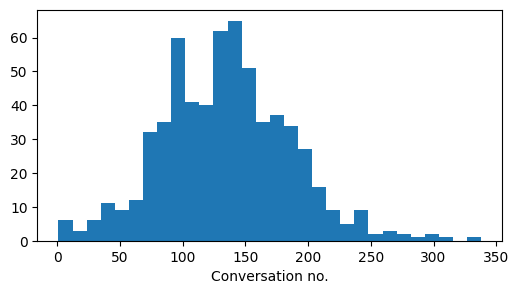

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(6,3))

axes.hist(convos.groupby('movie_id').count().line_ids, bins=30)
axes.set_xlabel('Conversation no.')

plt.show()

מפיזור כמויות השיחות בסרטים ניתן ללמוד כי מספר השיחות בכל סרט משתנה, וכי ברוב הסרטים יש בין 100 ל-200 שיחות. כמו כן נראה שיש סרטים עם מספר שיחות קטן מאוד (< 50), כלומר המידע לגביהם חסר או לא רלוונטי. נצטרך להתחשב בפערים אלו כאשר נבצע עיבוד לנתונים בהמשך.

כעת נבחן את פיזור הז'אנרים המשויכים לסרטים:

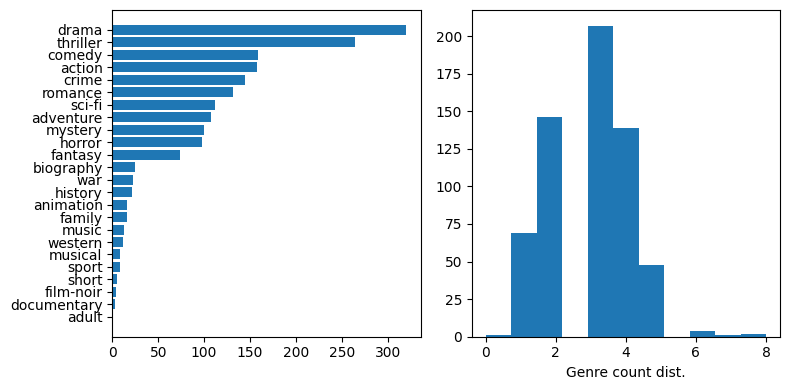

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

genre_counts = meta.explode('genre_list').genre_list.value_counts()

axes[0].barh(genre_counts.index, genre_counts.values)
axes[0].invert_yaxis()

axes[1].hist(meta.genre_list.apply(len), bins=11)
axes[1].set_xlabel('Genre count dist.')

plt.show()

הגרף משמאל מראה את כמות הסרטים בכל ז'אנר, והגרף מימין מראה את פיזור כמות הז'אנרים המשוייכים לכל סרט. מגרפים אלו ניתן ללמוד כמה דברים:
1. קיימים הבדלים מהותיים בין שלושה קבוצות של ז'אנרים:
    - דרמה ומתח הם הז'אנרים הפופולריים ביותר, ושניהם נמצאים במספר גדול מאוד של סרטים. עובדה זו הגיונית כיוון שדרמה ומתח הם כלליים יותר משאר הז'אנרים, אך ייתכן וכלליות זו תפגע ביכולת שלנו לסווג את הסרטים בצורה מדויקת בהמשך.
    - הקבוצה השנייה היא קבוצת הז'אנרים הסטנדרטית (אקשן, קומדיה וכו') שרוב הסרטים משוייכים לאחד מהז'אנרים בה
    - הקבוצה השלישית היא קבוצת ז'אנרים המינורים, שהם יותר ספציפיים ולא משותפים למספר גדול של סרטים. מקבוצה זו ככל הנראה נתעלם כאשר נרצה לאמן מודל לסיווג ז'אנרים.
2. רוב הסרטים משוייכים ל-3-5 ז'אנרים, אך קיימים סרטים שלהם 6-8 ז'אנרים או ז'אנר אחד.
    - מיעוט בז'אנרים יכול להביא לתוצאות פחות מדויקות, ומדובר בפער הקיים במאגר הנתונים (בפועל לסרטים אלו יש ז'אנרים נוספים) 
    - ריבוי ז'אנרים יכול להיות טוב, אך בפועל הז'אנרים הנוספים כנראה הם כאלו מינוריים שפחות מאפיינים באופן מהותי את הסרט, ולכן פחות רלוונטיים. 

### ניתוח טקסט בסיסי

כדי שנוכל לנתח את הטקסטים של הסרטים בנפרד, נגדיר פונקציות עזר שיחזירו  

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from lexical_diversity import lex_div as ld

def sample_genre(genre, n):
    return meta[meta.genre_list.apply(lambda x: genre in x)].sample(n)

STOP_WORDS = set(stopwords.words('english'))

def is_word(string: str):
    return string.isalpha() and string.lower() not in STOP_WORDS


def tokenize(text):
    return [w for w in word_tokenize(text) if is_word(w)]

def lexical_diversity(text):
    return ld.msttr(tokenize(text))


In [14]:
for mid, s in meta.sample(5).iterrows():
    texts = movie_texts(mid).to_list()
    data = [lexical_diversity(' '.join(ts)) for ts in np.array_split(texts, 20)]
    plt.plot(data, label=s['title'])
plt.legend()
plt.xlabel('Word offset') 
plt.ylabel('Lexical diversity') 
plt.ylim(0, 1)
plt.show()

NameError: name 'movie_texts' is not defined

In [ ]:
    
def movie_texts(movie_id) -> pd.Series:
    return lines[lines['movie_id'] == movie_id].text_pp

def genre_texts(genre, n):
    movies = sample_genre(genre, n)
    print(genre)
    print(movies.title)
    return lines.join(movies, on="movie_id", how="inner").text_pp


In [ ]:
from nltk.text import Text

crime_text = Text(tokenize(' '.join(genre_texts('crime', 5))))
comedy_text = Text(tokenize(' '.join(genre_texts('comedy', 5))))
horror_text = Text(tokenize(' '.join(genre_texts('horror', 5))))

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=60).generate(' '.join(comedy_text.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [ ]:
wordcloud = WordCloud(max_font_size=60).generate(' '.join(horror_text.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [ ]:
from nltk import FreqDist

plt.subplots(1, 3, figsize=(12, 3))
plt.subplot(131)
ax = FreqDist(comedy_text).plot(30, show=False)
ax.set_title("comedy")

plt.subplot(132)
ax = FreqDist(crime_text).plot(30, show=False)
ax.set_title("crime")

plt.subplot(133)
ax = FreqDist(horror_text).plot(30, show=False)
ax.set_title("horror")
plt.show()

In [ ]:
def dispersion_plot(text, words, ax, ignore_case=True):
    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text
    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    ax.plot(x, y, "b|", scalex=0.1)
    plt.yticks(list(range(len(words))), words, color="b")
    plt.ylim(-1, len(words))
    plt.xlabel("Word Offset")


In [ ]:
words = ["bad", "good", "night", "day", "shit", "dude", "hell"]

plt.subplots(1, 3, figsize=(12, 3))

ax = plt.subplot(131)
dispersion_plot(comedy_text, words.copy(), ax)
ax.set_title("comedy")

ax = plt.subplot(132)
dispersion_plot(crime_text, words.copy(), ax)
ax.set_title("crime")

ax = plt.subplot(133)
dispersion_plot(horror_text, words.copy(), ax)
ax.set_title("horror")
plt.show()


In [ ]:
horror_text.concordance("get")

In [ ]:
meta.loc['m126'].genre_list

In [ ]:
meta[meta.genre_list.apply(lambda x: len(x) <= 1)][['title', 'genre_list']]

## סיווג בעזרת TF-IDF


## אלגוריתם ניתוח סנטימנטלי

כפי שהזכרתי, המרכיב המרכזי שברצוננו לבחון הוא הקשר בין עוצמת הסנטימנטים לאורך סרט לבין הז'אנרים שלו. כדי לחלץ את המידע על הסנטימנטים מתוך הטקסט, נשתמש באלגוריתם ניתוח סנטימנטלי המבוסס על NLP. קיים מגוון רחב של אלגוריתמים שמבצעים משימה זו, אך האלגוריתם צריך לענות על כמה תנאים:
- האלגוריתם צריך להתמודד עם משפטים מורכבים הכוללים שלילה, שאלות וכו'. אלגוריתמים של למידה מפוקחת כמו אלו המסתמכים על מילה או מילים ספציפיות, לא יתנו מענה טוב כיוון שהם פשוטים ולא יעמדו בניואנסים של דיאלוג בסרט.
- האלגוריתם צריך לנתח מספר סנטימנטים, ולתת יותר מידע מחיובי/שלילי. זאת כדי לתת מענה לסיווג הז'אנרים נדרשת כמות גדולה יותר של פיצ'רים.
- האלגוריתם צריך להיות בצורת מודל מאומן, כיוון שהמידע שברשותנו לא מאפשר אימון מודל חדש עבור ניתוח סנטימנטלי.

לפיכך לשם ביצוע המשימה נבחר במודל ציבורי שאומן מראש מאתר [hugging-face 🤗](https://huggingface.co/), או ספציפית ב-[j-hartmann/emotion-english-distilroberta-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base). 

המודל מבוסס על מודל השפה DistilRoBERTa, שהוא גלגול של מודל השפה BERT המבוסס על transformers, שהם כלי מרכזי במשימות ניתוח טקסט. DistilRoBERTa הוא שיפור של BERT גם מבחינת ביצועים, וגם מבחינת כמות המידע שעליו המודל אומן.

השימוש במודל נעשה בעזרת ממשק ה-pipeline של 🤗 עם המשימה text-classification: 

In [20]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

המודל מאפשר לתייג מידע טקסטואלי באנגלית בעזרת 6 רגשות שונים, ובפרט קבוצת הרגשות האוניברסליים של [אקמן](https://www.paulekman.com/universal-emotions/):
כעס, פחד, עצב, שמחה, הפתעה וגועל, וכן גם הרגש הניטרלי.

המודל מקבל כקלט משפט או טקסט קצר כלשהו, ומחזיר רשימה שבה עבור כל רגש שהוזכר למעלה מוצמד שבר עשרוני, שאומר עד כמה הטקסט מתאים לאותו רגש:

In [ ]:
classifier("I don't feel like going out today")

המודל יודע להתמודד עם הרבה ניואנסים סמנטיים, ויש לו רמת דיוק גבוהה מאוד. אמנם עדיין קיימים משפטים שמשמעותם תלויה בהקשר שבו הם נאמרו, למשל המשפט: 

In [21]:
classifier("Are you serious!?")

[[{'label': 'surprise', 'score': 0.4399447739124298},
  {'label': 'anger', 'score': 0.397427499294281},
  {'label': 'disgust', 'score': 0.09223880618810654},
  {'label': 'neutral', 'score': 0.027384191751480103},
  {'label': 'sadness', 'score': 0.024068422615528107},
  {'label': 'fear', 'score': 0.012041479349136353},
  {'label': 'joy', 'score': 0.006894752848893404}]]

מקבל רגש שונה בנסיבות שונות, וכפי שניתן לראות בתוצאה, גם המודל מכיר בכך. אנו מניחים כי משפטים אלו זניחים ביחס למשפטים האחרים שהם כן חד-משמעיים ויתרמו יותר למידע הסנטימנטלי בסרט. 

### חלוקה לדיאלוגים 

לא ניתן לבצע ניתוח סנטימנטלי ראליסטי לתוכנו של הסרט ללא חלוקה כלשהי, שכן ניתוח של הסרט בשלמותו הוא ארוך מדי ודורש מודל מסוג אחר, וכן מאבד את מימד הזמן. מצד שני ניתוח בנפרד של כל משפט בסרט יכול לקחת הרבה זמן. לכן החלוקה של סרט לדיאלוגים/שיחות כפי שנמצאת במאגר מתאימה למטרתנו. כמו כן, הגבלת אורך הטקסט תצמצם את מרווח הטעייה של המודל ותחזק את תוצאת הניתוח.

למרות החלוקה לשיחות שנמצאת בטבלה convos, עדיין עלינו להגביל את אורך הטקסט שאנו מעבירים למודל, כיוון שהמודל מוגבל למספר מסויים של קלטים. ניתן לקבל את מספר זה מתוך ה-tokenizer של המודל:

In [ ]:
classifier.tokenizer.max_len_single_sentence

כדי להתמודד עם ההגבלה הזו, נחלק את שורות הסרטים לדיאלוגים. המטרה בחלוקה היא ליצור טקסטים בדידים קוהרנטים באורך מתאים, שיש להם מכנה משותף (שייכים לאותה שיחה).
נעשה זאת באופן הבא:
- כל שיחה תחשב כדיאלוג אחד לפחות
- אם אורך השיחה גדול מהאורך המותר, נחלק את השיחה לתת-שיחות לפי שורות, כך שכל תת-שיחה היא באורך המותר
- במקרה הקיצון ששורה ארוכה מדי, נקצץ את השורה. 

קיצוץ השורות הוא לא אופטימלי כיוון שהוא מאבד מידע, אבל ההנחה היא שכל שורה היא בעלת סנטימנטים יחסית אחידים, ולכן חלק ממנה בד"כ משליך על כולה.  

In [74]:
max_length = classifier.tokenizer.max_len_single_sentence
missing_lines = 0

def get_line_groups(lines: list[str]):
    curr_group = None
    for line in lines:
        if not curr_group:
            curr_group = line
        elif (len(curr_group) + len(line)) > max_length:
            yield curr_group
            curr_group = None
        else:
            curr_group = ' '.join([curr_group, line])
    if curr_group:
        yield curr_group

def get_lines_text(row):
    global missing_lines
    line_texts = []
    for id in str_to_list(row['line_ids']):
        if id not in lines.index:
            missing_lines += 1
            continue
        line = lines.loc[id].text_pp
        if len(line) > max_length:
            line = line[:max_length]
        line_texts.append(line)
    if sum([len(s) for s in line_texts]) <= max_length:
        return [' '.join(line_texts)]
    return get_line_groups(line_texts)

def get_dialog_texts():
    for i in range(len(convos)):
        convo = convos.iloc[i]
        texts = get_lines_text(convo)
        if not texts:
            continue
        for text in texts:
            yield {
                'first_char': convo.first_char,
                'second_char': convo.second_char,
                'movie_id': convo.movie_id,
                'text': text
            }
            
dialog_texts = pd.DataFrame(get_dialog_texts())
print('missing lines:', missing_lines)
dialog_texts.shape

missing lines: 459


(88098, 4)

אם נבדוק את פיזור כמות הטקסטים שנוצרו נקבל כי ההתפלגות דומה להתפלגות השיחות שקיבלנו למעלה: 

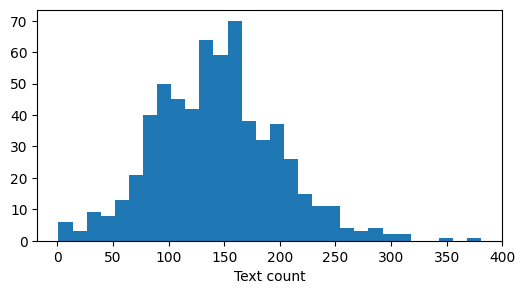

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(6,3))

axes.hist(dialog_texts.groupby('movie_id').count().text, bins=30)
axes.set_xlabel('Text count')

plt.show()

In [85]:
counts = dialog_texts.groupby('movie_id').count().text
movies_1 = meta.loc[counts[counts.between(145, 155)].index]
movies_1[movies_1.rating > 8]

,title,year,rating,no. votes,genres,genre_list
movie_id,,,,,,
m181,simone,2010,8.3,9,['short' 'drama' 'horror' 'thriller'],"[thriller, short, horror, drama]"
m203,the godfather,1972,9.2,419312,['crime' 'drama' 'thriller'],"[crime, thriller, drama]"
m34,blade runner,1982,8.3,188735,['drama' 'sci-fi' 'thriller'],"[sci-fi, thriller, drama]"
m347,fargo,1996,8.3,168176,['crime' 'drama' 'thriller'],"[crime, thriller, drama]"
m390,hotel rwanda,2004,8.3,94404,['adventure' 'drama' 'history' 'thriller' 'war'],"[war, history, drama, adventure, thriller]"
m465,on the waterfront,1954,8.4,42010,['crime' 'drama' 'romance'],"[romance, crime, drama]"
m539,sunset blvd.,1950,8.7,55994,['drama' 'film-noir'],"[film-noir, drama]"
m579,toy story,1995,8.2,156231,['animation' 'adventure' 'comedy' 'family' 'fa...,"[adventure, animation, comedy, family, fantasy]"
m591,unforgiven,1992,8.3,101270,['drama' 'western'],"[western, drama]"


### חילוץ סנטימנטים 

כעת נעבור לשימוש ב-classifier כדי לחלץ מתוך הטקסטים שקיבלנו את הסנטימנטים בכל סרט. נגדיר פונקציות עזר כדי להמיר את הסנטימנטים לfeatres ולDataFrame:

In [76]:
from tqdm.auto import tqdm

def get_emotion_feats(classifier_res):
    return {x['label']: x['score'] for x in classifier_res[0]}

def get_emotions(texts):
    for i in tqdm(range(texts.shape[0])):
        row = texts.iloc[i]
        feats = get_emotion_feats(classifier(row.text))
        feats['movie_id'] = row.movie_id
        feats['text'] = row.text
        yield feats

נחלץ את הסנטימנטים של סרט לדוגמה, נבחר למשל את הסרט "הסנדק": 

In [86]:
mid = 'm579'
emots = pd.DataFrame(get_emotions(dialog_texts[dialog_texts.movie_id == mid]))

  0%|          | 0/152 [00:00<?, ?it/s]

In [89]:
emots.head()

,surprise,joy,neutral,anger,sadness,disgust,fear,movie_id,text
0,0.651263,0.305251,0.019376,0.010028,0.007724,0.003237,0.003122,m579,Whadda ya think? Wow! Cool! Oh this looks GRE...
1,0.039633,0.110575,0.404812,0.237318,0.063543,0.049081,0.095038,m579,Can we leave this up 'til we move? Now go get ...
2,0.136516,0.699980,0.095587,0.037198,0.019940,0.004947,0.005833,m579,Come on down guys. It's time for games! We'v...
3,0.467080,0.199741,0.184751,0.037866,0.080931,0.018086,0.011544,m579,Oh all this packing makes me hungry. What wou...
4,0.161692,0.008879,0.785790,0.016290,0.015057,0.009662,0.002629,m579,Just one? You can bring ONE toy... Can I bring...


נוכל להציג את עוצמת הסנטימנטים שקיבלנו לאורך הסרט בצורה גרפית:

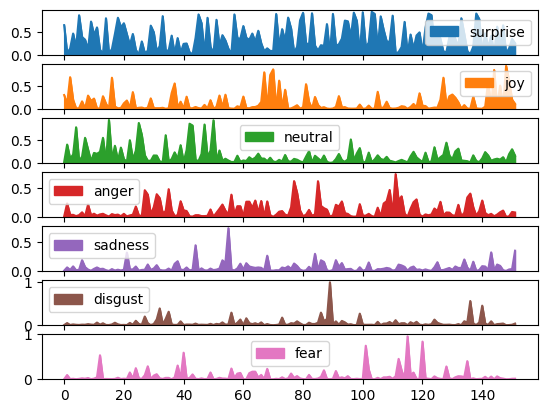

In [113]:
ax = emots.plot.area(subplots=True)
plt.show()

ניתן הסיק כמה מסקנות מהגרפים לעיל:
- קיימים סנטימנטים שנמצאים ברמה יחסית אחידה לאורך הסרט, כמו "הפתעה" במקרה הזה
- חלק מהסנטימנטים מקבלים עליות חדות מדי פעם במהלך הסרט, כמו עצבות, אבל הם אינם בהכרח מבטאים עלייה משמעותית באותו סנטימנט כיוון שמדובר במשפטים בודדים.
- אבל, יש סנטימנטים שמהם ניתן להסיק מסקנות בסבירות גבוהה יותר, כמו "אושר", שהעליות והירידות בו הן בטווחי זמן ארוכים יותר וכנרה מבטאים שינוי מהותי בסרט.

In [3]:
# movie_emots = pd.DataFrame(get_emotions(dialog_texts))
movie_emots = pd.read_pickle('./data/movie_emots')

In [4]:
movie_emots.movie_id.unique().shape

(617,)

### סיווג בעזרת מודלים

כדי לנסות לבצע סיווג ז'אנרים על פי המידע הסנטימנטלי, עלינו ראשית לצמצם את מספר הפיצ'רים. כרגע המידע שאספנו מכיל מספר לא קבוע של רשומות עבור כל סרט, ולרוב זהו מספר גדול. לכן נבצע צמצום של המידע הסנטימנטלי על ידי ביצוע ממוצע של כל סנטימנט:

In [5]:
movie_avg_emots = movie_emots.drop(['text'], axis=1).groupby('movie_id').agg(np.average)

אם נבדוק את גדלי הסנטימנטים נראה שחלק מהסנטימנטים באופן קבוע מופיעים יותר מאחרים, כמו למשל הרגש הניטרלי. לכן נבצע נרמול של ערכי הסנטימנטים. 

<AxesSubplot: >

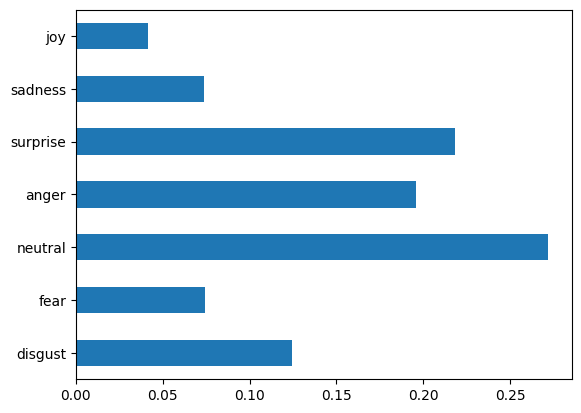

In [237]:
movie_avg_emots.head().apply(np.average).plot.barh()

In [6]:
normalized = (movie_avg_emots-movie_avg_emots.mean())/movie_avg_emots.std()

איחוד הערכים לכדי ממוצע כרוך באובדן של מידע, כיוון שאנו מתעלמים בכך ממימד הזמן, והשינויים בסנטימנטים במהלך הסרט. אך למטרתנו כרגע הממוצע מפשט בהרבה את הפיצ'רים וייתן מענה מספיק.

לפני שניגש לסיווג ננסה להמחיש את מידת ההשפעה של כל סנטימנט על הז'אנר: 

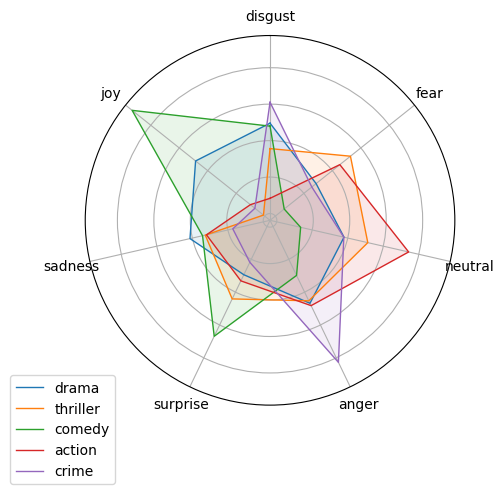

In [143]:
from math import pi

avg_emots_genres = normalized.join(meta[['genre_list']], on="movie_id", how="inner")
genre_avgs = avg_emots_genres.explode('genre_list').groupby('genre_list').agg(np.average)

def show_spider(data: pd.DataFrame, label_col: str = None):
    categories = (data.drop(label_col, axis=1) if label_col else data).columns.to_list()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.axes.get_yaxis().set_ticklabels([])
    for id, v in data.iterrows():
        values = (v.drop(label_col) if label_col else v).values.tolist()
        values += values[:1]
        label = str(v[label_col]) if label_col else id
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    if len(data) > 1:
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

show_spider(genre_avgs.loc[genre_counts.nlargest(5).index[0:]])

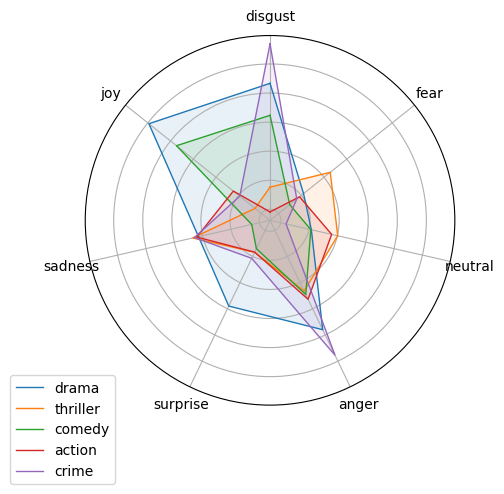

In [145]:
genre_stds = avg_emots_genres.explode('genre_list').groupby('genre_list').agg(np.std)
genre_stds = (genre_stds-genre_stds.mean())/genre_stds.std()
show_spider(genre_stds.loc[genre_counts.nlargest(5).index[0:]])

בגרף לעיל מוצגים הז'אנרים הכי פופולריים מלבד "דרמה" ו"מתח" (שהם כלליים יותר כפי שהוזכר לעיל), והערך הממוצע המתאים להם עבור כל סנטימנט. ממבט ראשון ניתן לראות כי קיימים קורלציות בין ערכי הסנטימנטים לז'אנרים, ואף הם עולות בקנה אחד עם האינטואיציה.

כעת ננסה להשתמש בממוצעי הסנטימנטים עבור אימון מודלים של למידה מפוקחת בסיסיים, כאלו הקיימים ב-sklearn. משימת התיוג היא מרובת תגיות כיוון שלכל סרט יכולים להיות כמה ז'אנרים, לכן היא מורכבת יותר ממשימת סיווג רגילה. על פי [הדוקומנטציה הרשמית של sklearn](https://scikit-learn.org/stable/modules/multiclass.html), הרבה מהמודלים הקיימים של למידה מפוקחת כמו RandomForestTree ו NaiveBayes מתאימים באופן מובנה לסיווג של מספר תגיות, לכן נוכל להשתמש בהם כרגיל.

בגלל כמות הז'אנרים המשתנה שהוזכרה למעלה, נמצא את 5 הז'אנרים הכי פופולריים, וסנן את הז'אנרים של הסרטים על פי רשימה זו. לאחר מכן נחלק את הנתונים לקבוצת אימון וקבוצת בדיקה בעזרת train_test_split של sklearn.

אנו משאירים בתוך ה-dataset שלנו גם סרטים שלא מכילים את הז'אנרים הפופולריים שבחרנו, כיוון שגם רשימה ריקה של תגיות יכולה לעזור בתהליך הסיווג.

In [155]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

top_genres = genre_counts.nlargest(5).index
print('top genres:', top_genres.to_list())

def get_genre_sets(genres):
    X = np.array(avg_emots_genres.iloc[:, 0:7])
    filtered_genres = [[g for g in x if g in genres] for x in avg_emots_genres.genre_list]
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(filtered_genres)
    return train_test_split(
        X, y, test_size=0.1, random_state=1) + [mlb]

X_train, X_test, y_train, y_test, mlb = get_genre_sets(top_genres)

top genres: ['drama', 'thriller', 'comedy', 'action', 'crime']


כדי להשתמש במסווג עם כמה תגיות לכל רשומה, השתמשנו לעיל ב-[MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) כדי להמיר כל רשימת ז'אנרים למערך בינארי, כך שכל אינדקס במערך מתאים לז'אנר אחר. לדוגמה:

In [156]:
mlb.transform([['action', 'comedy']])

array([[1, 1, 0, 0, 0]])

כעת נאמן מודל קלאסי של RandomForest על סט האימון:

In [147]:
from sklearn.ensemble import RandomForestClassifier 
rf_clf = RandomForestClassifier(n_estimators=100, random_state=1)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

ננסה למדוד את מידת הדיוק של המודל על סט הבדיקה בעזרת score:

In [148]:
rf_clf.score(X_test, y_test)

0.20967741935483872

קיבלנו מספר נמוך, מכיוון שאנו משתמשים בסיווג MultiLabel. החישוב הרגיל של score מחלק את מספר הסיווגים הנכונים במספר הרשומות, וכאן בסיווג רב-תגי סיווגים נכונים הם סיווגים שהתאימו את הז'אנרים באופן מדויק. לכן כל סיווג שהוא נכון באופן חלקי, יחשב אוטומטית כלא נכון, ויוריד מהציון.

כדי לתת מענה לבדיקת רמת הדיוק של המודל, עלינו להפריד בין הסוגים השונים של סיווג לא נכון - 
1. False Positive (FP) = תיוג סרט כבעל ז'אנר מסוים בניגוד למידע הנתון
2. False Negative (FN) = אי-תיוג סרט עם ז'אנר שנמצא במידע הנתון

קיימים [מדדים אחרים](https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics) לבדיקת מידת הדיוק של מסווגים, שמתייחסים לסוגי השגיאות לעיל: 
- מדד precision, מחשב את את הדיוק של כל סיווג רשומה בנפרד ע"י חילוק מספר התגיות שתויגו נכון חלקי מספר התגיות שתויגו בסה"כ, ואז מחשב את הממוצע. מדד זה נותן ציון עבור הסיווגים החיוביים (Positive) 
- מדד recall מבצע חישוב דומה, אך מדד הדיוק של כל רשומה נמדד ע"י חילוק מספר התגיות שתויגו נכון חלקי מספר התגיות האמיתי. מדד זה נותן ציון עבור אי-הסיווגים (Negative) 
- מדד f1 שהוא שילוב של 2 המדדים recall ו-precision 

עבור כל מדד שהוזכר, הממוצע של כל מדד יכול להתבצע בכמה דרכים, macro, micro, weighted, ו-samples. לא ניכנס לפרטים איך כל אחד מחושב, למטרתנו יספיק להתמקד באחד מהם. את הנתונים שהזכרנו ניתן להציג בעזרת הפונקציה classification_report: 

In [157]:
from sklearn.metrics import classification_report

def report_clf(clf, X, y, classes):
    y_predict = clf.predict(X)
    return classification_report(
        y,
        y_predict,
        target_names=classes,
        zero_division=1
    )

print(report_clf(rf_clf, X_test, y_test, mlb.classes_))

              precision    recall  f1-score   support

      action       0.50      0.05      0.09        20
      comedy       0.71      0.26      0.38        19
       crime       0.50      0.07      0.12        14
       drama       0.62      0.72      0.67        32
    thriller       0.61      0.58      0.60        24

   micro avg       0.62      0.40      0.49       109
   macro avg       0.59      0.34      0.37       109
weighted avg       0.60      0.40      0.43       109
 samples avg       0.67      0.44      0.44       109



קיבלנו ציונים גבוהים יותר ומידע מפורט יותר. בפרט נראה שערכי הpercision גבוהים יותר מה-recall, כלומר שגיאות FN (תיוג חסר) נפוצות יותר משגיאות FP (תיוג עודף). 

נראה שיש הבדל משמעותי בין הז'אנרים. כדי להמחיש את התמונה טוב יותר נציג את ה-confusion matrix המתאים לכל ז'אנר: 

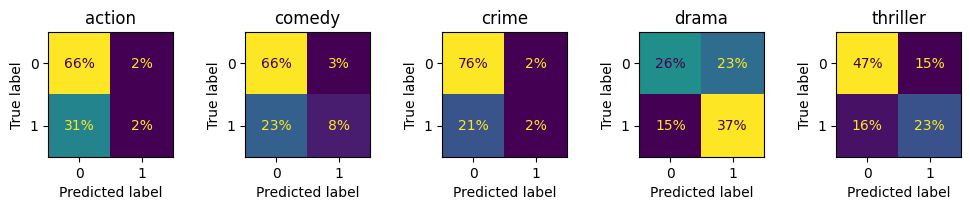

In [160]:
y_predict = rf_clf.predict(X_test)

def show_conf_matrices(y_test, y_predict, classes, axs):
    i = 0
    for cm in multilabel_confusion_matrix(y_true=y_test, y_pred=y_predict):
        genre = classes[i]
        axs[i].set_title(genre)
        s = cm.sum()
        cm_percent = np.array([[x / s for x in r] for r in cm])
        ConfusionMatrixDisplay(cm_percent).plot(ax=axs[i], colorbar=False, values_format=".0%")
        i += 1

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
show_conf_matrices(y_test, y_predict, mlb.classes_, axs)
plt.tight_layout()


נראה שהז'אנרים הבעייתיים ביותר הוא "דרמה" ו"מתח" - שגיאת ה-FP של שניהם גבוה יותר משאר הז'אנרים. כפי שהזכרנו לעיל אלו 2 הז'אנרים הכלליים והנפוצים יותר שנמצאים במאגר, ולכן הגיוני כי המודל שלנו סיווג הרבה מהסרטים כדרמה ומתח למרות שבפועל הם לא מתויגים כך.

מצד שני, שלושת הז'אנרים האחרים הם בעלי שגיאת FP כמעט אפסית, אך שגיאת ה-FN עדיין גדולה. הסבר אפשרי לגבי הז'אנר "פעולה" למשל, הוא שייתכן וגם הוא יחסית כללי ולכן השגיאה בו יחסית גבוהה, אך גם בז'אנר "פשע" יש שגיאת FN גבוהה. הסבר אחריכול להיות מספר נתונים לאימון קטן, שכן על פי המטריצות שלושת הז'אנרים הללו נמצאים רק  ב-20-30% מסך סט האימון. הסבר שלישי יכול להיות פשוט חוסר תאימות בנתונים.

ניתן לבדוק את ההשפעה של דרמה ומתח על ידי אימון מודל חדש בלעדיהם:

genres: ['comedy', 'action', 'crime']


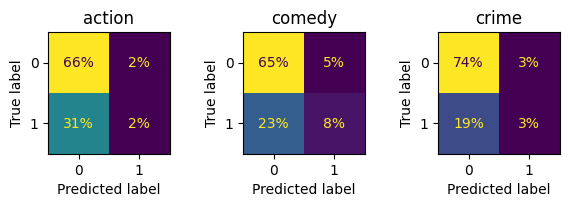

In [164]:
next_genres = genre_counts.nlargest(5).index[2:]
print('genres:', next_genres.to_list())
X_train_1, X_test_1, y_train_1, y_test_1, mlb_1 = get_genre_sets(next_genres)
rf_clf_1 = RandomForestClassifier(n_estimators=100, random_state=1)
rf_clf_1.fit(X_train_1,y_train_1)
y_predict_1 = rf_clf_1.predict(X_test_1)
fig, axs = plt.subplots(1, 3, figsize=(6, 2))
show_conf_matrices(y_test_1, y_predict_1, mlb_1.classes_, axs)
plt.tight_layout()

נראה כי ערכי הrecall של שלושת הז'אנרים נשארו כפי שהם. לכן לדרמה ומתח לא היתה השפעה משמעותית על השגיאות בסיווג שאר הז'אנרים, וככל הנראה הן נובעות מההסברים שהבאנו לעיל, כלומר בעיות שנובעות מהנתונים עצמם.

### חילוץ פיצ'רים מתקדם

## קלאסטרינג עם TimeSeries


### עיבוד מקדים

### אלגוריתם K-Means